# Decision Trees

> This is the Summary of lecture "Machine Learning Algorithms: Supervised Learning Tip to Tail" from Coursera.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Machine_Learning]
- image: 

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from io import StringIO
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from pydotplus import graph_from_dot_data
from IPython.display import Image

NumPy will show floating point (real) numbers in the scientific notation. Let's turn that off.

In [2]:
np.set_printoptions(suppress=True)

## Loading and examining the data

Let's load our data into a pandas data frame (`DataFrame`), which are good tools for manipulating, an in our case for now, displaying the data. We will load our data from a CSV (Comma-Separated Values) file.

In [3]:
df = pd.read_csv('./dataset/data_decision_trees.csv')

It's very good practice to check your data before trying to build a QuAM. We are talking about the methods themselves now. This seems optional because we have clean and completely useful data and we know exactly what we want to do. However, this will become a crucial thing to do once you get into real-world applications since you have to understand your data and convert it into a useful form. Oftentimes, that is one of the parts of the machine learning process that is going to take the most time. That process will be the focus of later courses in the specialization. However, let's do the good practice anyway. Some of our best tools for checking our data is to see them in tables and figures.

So, let's take a peek at our data (as a table) to see if everything is alright. We will ask the Jupyter notebook to show the data frame object `df` that we loaded with the data from the CSV file. Calling an object will let us inspect that object and in the case of pandas data frames, this shows us the data frame as a table:

In [4]:
df

Feature 01  Feature 02  Feature 03  Feature 04  Feature 05  Feature 06  \
0       0.269186    2.890367    1.893983   -0.420737   -0.828978   -3.815491   
1      -1.327319   -1.762721    1.031584    2.766727   -3.174990   -1.395544   
2       0.107028    3.964838    1.073601    0.758348    1.570392   -0.401011   
3      -2.294776   -3.894267   -0.571486    3.067353    2.892005   -0.235421   
4      -1.635072    4.305268    0.101267   -5.335998    1.072216    1.286368   
...          ...         ...         ...         ...         ...         ...   
1865   -0.478231    2.201073   -1.444069   -2.515373    1.695445    4.027665   
1866    0.888738   -2.017106    2.039652    2.001606    1.426542    1.720450   
1867   -3.077087    1.400107    0.663180    3.309129    0.672774    2.550213   
1868    0.803133    1.580357    0.054739    2.958573    3.340849   -1.811113   
1869   -0.480225    3.952867    0.886747   -0.960139    2.574765    0.233662   

      Feature 07 Label  
0      -1.219257     B  
1      -3.284436     D  
2       3.332441     C  
3      -1.292745     A  
4       4.741389     A  
...          ...   ...  
1865    1.092670     B  
1866    0.886203     B  
1867    0.038810     C  
1868    0.176597     C  
1869    3.803253     D  

[1870 rows x 8 columns]

Cool. Everything seems fine. One of the other tools for checking our data is visualizing the data. However, our data has more than 3 features, so we cannot directly visualize it (We can directly see only up to 3D). One good way to check for statistical shape of the data is to use a matrix of scatter plots. We can get a feel for the distribution of our data using that.

We are using data visualization tools from the plotly package. We are going to ask plotly to show us a scatter matrix. However, we care only to see the dimensions of the data that are features and the label part should be used to show different classes in different colours. Also, the plotly will try to fit the entire scatter matrix to the width of our screen and with data with high number features, we don't want that because it may give small pairwise scatter plots, so let's specify a size of 256 pixels for the size of each scatter plot. We ask plotly to create a figure for us and show it:

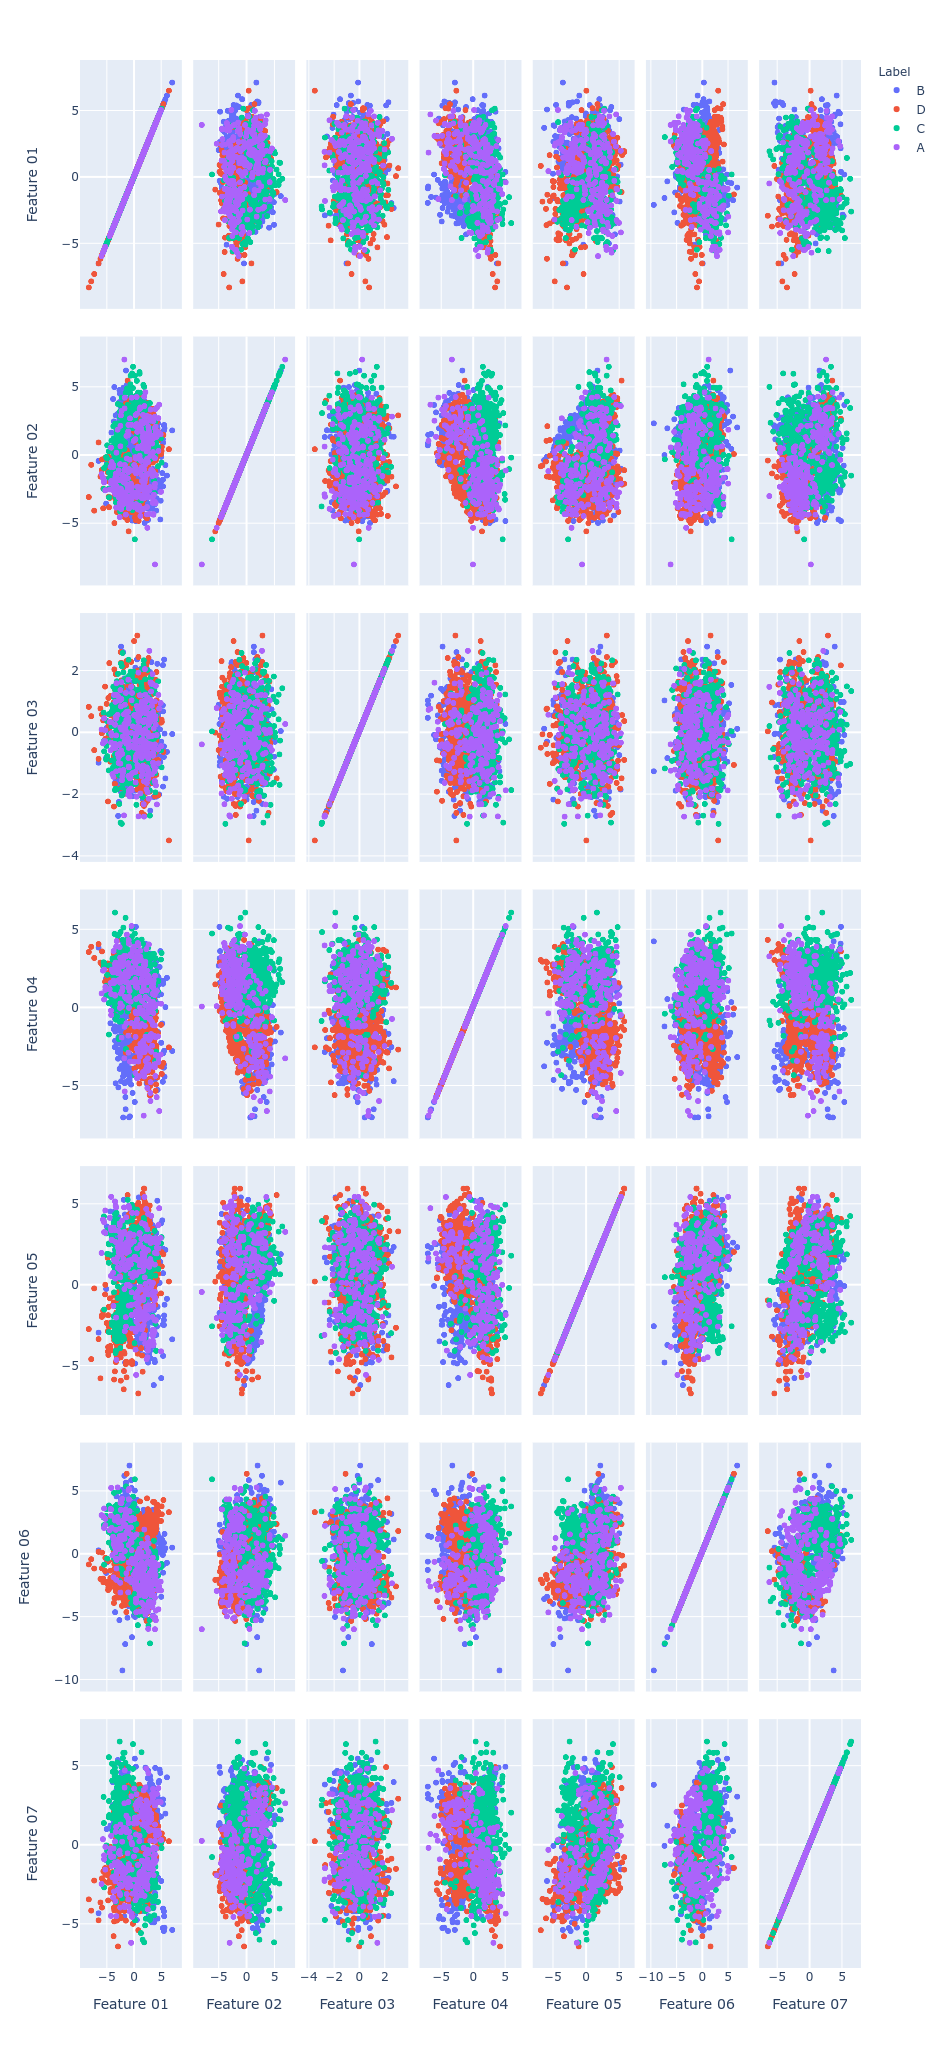

In [5]:
data_dimensions = df.columns[:-1].to_list()
figure_size = df.shape[1] * 256

fig = px.scatter_matrix(df, dimensions=data_dimensions, color='Label', width=figure_size, height=figure_size)
fig.show()

Now that everything seems good, let's get our data as NumPy arrays that will be used by scikit-learn algorithms. Our data `X` will be a matrix which has different datapoints in different rows and different features in different columns and since the `'Label'` column of the datafram `df` is not a feature of the data (but rather the label), let's exclude that. Then, our labels (or _targets_) `y` will be a vector consisting of simply that `'Label'` column of data frame `df`.

In [6]:
X = df.drop('Label', axis=1).to_numpy()
y = df['Label'].to_numpy()

Let's see if everything is fine. Let's see our data `X`:

In [7]:
X

array([[ 0.26918561,  2.89036704,  1.89398331, ..., -0.82897781,
        -3.81549087, -1.21925709],
       [-1.32731927, -1.76272079,  1.03158355, ..., -3.17499021,
        -1.39554398, -3.28443589],
       [ 0.10702806,  3.96483754,  1.07360074, ...,  1.57039201,
        -0.40101058,  3.33244142],
       ...,
       [-3.07708661,  1.40010747,  0.66318026, ...,  0.67277394,
         2.55021337,  0.03881049],
       [ 0.80313316,  1.58035675,  0.05473856, ...,  3.34084891,
        -1.81111266,  0.17659685],
       [-0.48022462,  3.95286668,  0.88674666, ...,  2.57476504,
         0.23366233,  3.80325314]])

Good. Now let's check the shape of `X`. We should have 1870 rows since we have 1870 datapoints and we should have 7 columns since there are 7 fetaures on our data:

In [8]:
X.shape

(1870, 7)

Let's do the same check with the targets vector `y`:

In [9]:
y

array(['B', 'D', 'C', ..., 'C', 'C', 'D'], dtype=object)

...and the shape of `y` should be the same number of rows and singular in column (so there is only a row dimension and no column dimension):

In [10]:
y.shape

(1870,)

## Splitting the data

Now, remeber we emphasized the importance of splitting your data into train, validation and held-out test sets? Let's put that into use. We will talk about this splitting later on in this course and you don't need to understand how this function works, however, we will provide a short explanation for those of you who are interested.

Unfortunately, scikit-learn does not have a function to divide the data into three parts, only a function that splits the data into two. So, we are goign to call that function twice, once to split data into two sets: _a._ training; and _b._ validation and test combined. Then, we call the function once more to split that second set into distinct validation and test sets. We chose to reserve 0.4 (or 40%) of our data for validation and test and 1 - 0.4 = 0.6 or 60% of our data for training. From the 40% left for validation and test, we are going to use 0.5 or 50% of it (which make sit 20% of the total amount of data) for validation and the other 50% for test.

In [11]:
(X_train, X_vt, y_train, y_vt) = train_test_split(X, y, test_size=0.4, random_state=0)
(X_validation, X_test, y_validation, y_test) = train_test_split(X_vt, y_vt, test_size=0.5, random_state=0)

## Building and fitting a decision tree

Finally, it's time to build your decision tree. Remember, we create an object of the class `DecisionTreeClassifier` first. Let's set the name `dtree` for that object. In Python, you create an object of class `Clss` with its parameter `par` set to value `val` and assign it a name of `obj` by saying:

`obj = Clss(par=val)`

You can see the documentation for `DecisionTreeClassifier` here:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

So, go ahead and create that decision tree now (also remember we are not specifying any parametes for our decision tree this time):

In [12]:
dtree = DecisionTreeClassifier()

Next step is to train our decision tree model. Again, remember we use the function (or method) `fit` of our decision tree object to do that. In Python, you call a method `mthd_a` of an object `obj`, which takes arguments `arg_a1` and `arg_a2` by saying:

`obj.mthd_a(arg_a1, arg_a2)`

You can see the documentation for `fit` method here:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.fit

Now, go ahead and fit your `dtree` to the training data and don't forget to pass the `X_train` training data and `y_train` training targets required for fitting:

In [13]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

## Visualizing the decision tree

Now, let's visualize our decision tree. Let's export our model as a special kind of data, create a visual representation form that, generate a graph from that representation and show that graph as an image (it may be a big image, so you may have to scroll to see the whole thing):

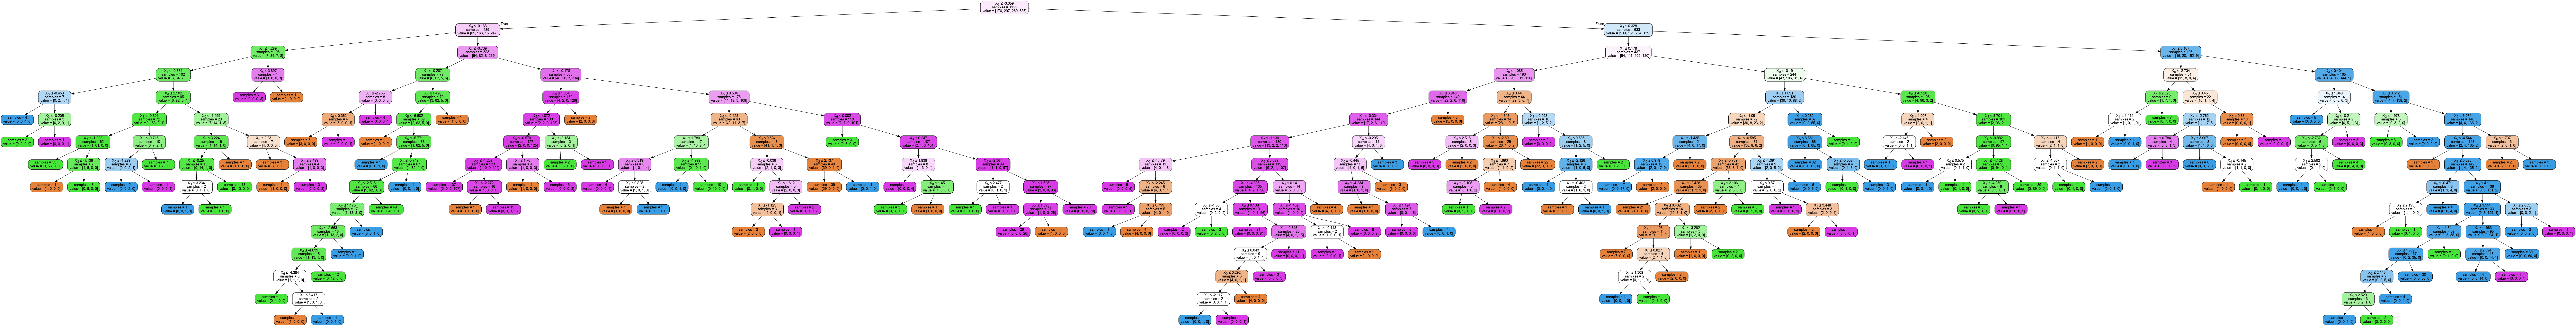

In [15]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, filled=True, rounded=True, impurity=False, special_characters=True)
graph = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png(), unconfined=True)

## Model assessment and selection

So let's evaluate our QuAM. First, let's see what happened on training data. You are going to put in the code that asks our decision tree `dtree` to predict the label for training data `X_train` and assign it to a vector variable `yhat_train`. Remember that the `predict` is the name of the method that asks a model object to predict labels. Again, you call a method `mthd_b` of an object `obj` that takes argument `arg_b1` and assign it to a variable `var` by doing:

`var = obj.mthd_b(arg_b1)`

You can see the documentation for `predict` method here:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict

So predict the labels of the training data and assign it to `yhat_train`:

In [16]:
yhat_train = dtree.predict(X_train)

Now we can assess the accuracy of our classification model between the `yhat_train` you computed and the actual alebls that came with the training data, `y_train`:

In [17]:
accuracy_score(yhat_train, y_train)

1.0

A perfect 1.0 or 100%! However, that was what was expected given the minimum leaf size was 1, we let the decision tree split leafs with even 2 points in them and we had no tree depth limittation among other things.

Let's use our validation data then. Calculate `yhat_validation` by asking `dtree` to predict labels for `X_validation`. Then, we can calculate the score for validation data.

In [18]:
yhat_validation = dtree.predict(X_validation)
accuracy_score(yhat_validation, y_validation)

0.8128342245989305

Right. The accuracy on validation data is much lower (should be ~0.???? or ??.??%). Maybe we have overfit to our data. Unrestricted decision trees do that.

Let's create a new decision tree object `dtree2`, but this time let's set a minimum number of samples per leaf. Let's do 15. Go ahead and create `dtree2`, however, this time specify that you want the `min_samples_leaf` to be set to 15. Then, just fit your model to the training data and targets, `X_train` and `y_train`:

In [22]:
dtree2 = DecisionTreeClassifier(min_samples_leaf=15)
dtree2.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=15)

Now, predict `yhat_train2`, so we can the accuracy on training data:

In [24]:
yhat_train2 = dtree2.predict(X_train)
accuracy_score(yhat_train2, y_train)

0.8440285204991087

Training accuracy is predictably lower (~0.???? or ??.??%) as we restrcited our decision tree, so it does not fit perfectly to training data because of its constraints.

Let's predict `yhat_validation2` and we can the accuracy on validation data:

In [25]:
yhat_validation2 = dtree2.predict(X_validation)
accuracy_score(yhat_validation2, y_validation)

0.7887700534759359

## Evaluating the decision tree

Finally, let's use the test data to get a final accuracy performance number for our model. Predict `yhat_test2` using `dtree2`. We can then calculate the accuracy on test data:

In [26]:
yhat_test2 = dtree2.predict(X_test)
accuracy_score(yhat_test2, y_test)

0.7647058823529411

Voila! The accuracy on test data (~0.???? or ??.??%), on validation data and on training data are close to each other, which is a good sign.

Well done!